In [8]:
from collections import Counter
from datetime import datetime
import json

from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from IntegratedGradients import * 
from keras.models import load_model
import pickle
import numpy as np
from matplotlib import pyplot as plt
# caleb_path = '/Users/CalebKaijiLu/Documents/yelp_dataset/'
caleb_path = '/home/caleb/schoolwork/yelp_dataset/'
selva_path = ''

/home/caleb/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [ ]:
def word_to_embedding(embeddings,data):
    N = embeddings.shape[0]
    M = embeddings.shape[1]
    embeddings_aug = np.zeros([N+1,M])
    embeddings_aug[1:,:]=embeddings
    return embeddings_aug[np.array(data)]

In [ ]:

t1 = datetime.now()
with open(caleb_path + "review.json") as f:
    reviews = f.read().strip().split("\n")
# reviews = reviews[:10000]
reviews = [json.loads(review) for review in reviews]
print(datetime.now() - t1)

In [ ]:
# Get a balanced sample of positive and negative reviews
# texts = [review['text'] for review in reviews]
reviews = [review for review in reviews if review['stars']!=3 ]
# Convert our 5 classes into 2 (negative or positive)
binstars = [0 if review['stars'] < 3 else 1 for review in reviews]
balanced_texts = []
balanced_labels = []
limit = 200000  #Change this to grow/shrink the dataset
neg_pos_counts = [0, 0]
for i in range(len(texts)):
    polarity = binstars[i]
    if neg_pos_counts[polarity]<limit:
        balanced_texts.append(texts[i])
        balanced_labels.append(binstars[i])
        neg_pos_counts[polarity]+=1

In [ ]:
Counter(balanced_labels)

In [ ]:
tokenizer = Tokenizer(num_words=5)
toytexts = ["Is is a common word", "So is the", "the is common", "discombobulation is not common"]
tokenizer.fit_on_texts(toytexts)
sequences = tokenizer.texts_to_sequences(toytexts)


# >>> [[1, 1, 4, 2], [1, 3], [3, 1, 2], [1, 2]]

In [ ]:
print(sequences)
# >>> [[1, 1, 4, 2], [1, 3], [3, 1, 2], [1, 2]]

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
data = pad_sequences(sequences, maxlen=300)

In [ ]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=300))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(data, np.array(balanced_labels), validation_split=0.5, epochs=3,batch_size = 32)

In [ ]:
# save the tokenizer and model
with open("keras_tokenizer_server.pickle", "wb") as f:
        pickle.dump(tokenizer, f)
model.save("yelp_sentiment_model_server.hdf5")

# Loading the Model & Tokenizer

In [9]:
with open("keras_tokenizer_server.pickle", "rb") as f:
       tokenizer = pickle.load(f)

model = load_model("yelp_sentiment_model_server.hdf5")

# Use the tokenizer to generate input for the model

In [26]:
# replace with the data you want to classify
newtexts = ["The food is"]
word_sequences = text_to_word_sequence(newtexts[0])
# note that we shouldn't call "fit" on the tokenizer again
sequences = tokenizer.texts_to_sequences(newtexts)
data = pad_sequences(sequences, maxlen=300)

# get predictions for each of your new texts
predictions = model.predict(data)
print(predictions)
print(word_sequences)

[[ 0.6251086]]
['the', 'food', 'is']


# Integrated Gradients (Not working really well, need to improve)

[[ 0.98756802]]
['the', 'food', 'is', 'amazing']
(2,)
Evaluated output channel (0-based index): All
Building gradient functions
[<tf.Tensor 'embedding_3_1/Gather:0' shape=(?, 300, 128) dtype=float32>, <tf.Tensor 'dropout_3/keras_learning_phase:0' shape=<unknown> dtype=bool>] [<tf.Tensor 'gradients_14/AddN_7:0' shape=(?, 300, 128) dtype=float32>]
Progress: 100.0%
Done.
Haha
(50, 300, 128)
1
[296 297 298 299]
(4,)


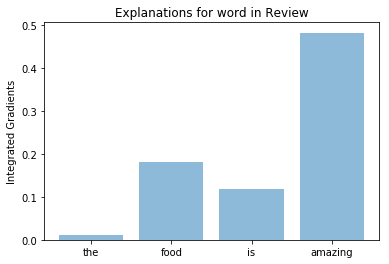

In [23]:
embeddings = model.layers[0].get_weights()[0]
word_embeddings = word_to_embedding(embeddings,data)
ig = integrated_gradients(model)
explanations = ig.explain(word_to_embedding(embeddings,data))
print(len(explanations))
final_explanations = np.abs(np.sum(explanations[0],axis = 1))
print(np.where(final_explanations!=0)[0])
final_explanations = final_explanations[np.where(final_explanations!=0)]
print(final_explanations.shape)
y_pos = np.arange(len(final_explanations))
plt.bar(y_pos,final_explanations,align='center', alpha=0.5)
plt.xticks(y_pos, word_sequences)
plt.ylabel('Integrated Gradients')
plt.title('Explanations for word in Review')
plt.show()

In [24]:
model.predict('The food is amazing')
model.predict('The food is')

TypeError: Error when checking model : data should be a Numpy array, or list/dict of Numpy arrays. Found: The food is amazing...